In [1]:
# Imports

%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from PIL import Image

import gzip
import urllib

import code

import tensorflow.python.platform
import tensorflow as tf

import warnings
warnings.simplefilter(action='ignore')

from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, TensorBoard
from keras.utils import to_categorical 
from sklearn.metrics import accuracy_score, f1_score
from datetime import datetime

Using TensorFlow backend.


In [2]:
from tf_aerial_images import *

In [3]:
IMAGE_SIZE = 400
N_LAYERS = 4

In [4]:
# Helper functions

def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

In [5]:
# Load a set of images
root_dir = "training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(20, len(files)) # Load maximum 20 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

n = 10 # Only use 10 images for training

Loading 20 images
satImage_001.png
Loading 20 images
satImage_001.png


In [6]:
print(len(files))

100


Image size = 400,400


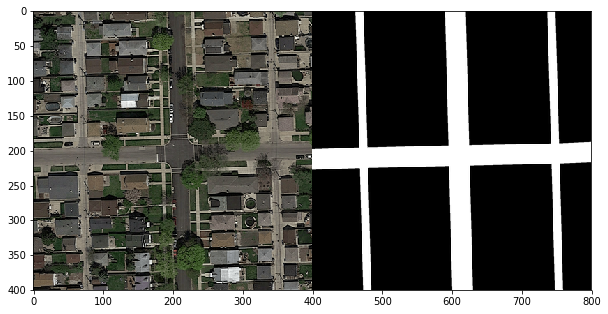

In [7]:
print('Image size = ' + str(imgs[0].shape[0]) + ',' + str(imgs[0].shape[1]))

# Show first image and its groundtruth image
cimg = concatenate_images(imgs[0], gt_imgs[0])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

In [8]:
# Extract patches from input images
patch_size = 16 # each patch is 16*16 pixels

img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]

# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

# Data Augmentation
https://medium.com/ymedialabs-innovation/data-augmentation-techniques-in-cnn-using-tensorflow-371ae43d5be9
## Image Scaling

In [8]:
def central_scale_images(X_imgs, scales):
    # Various settings needed for Tensorflow operation
    boxes = np.zeros((len(scales), 4), dtype = np.float32)
    for index, scale in enumerate(scales):
        x1 = y1 = 0.5 - 0.5 * scale # To scale centrally
        x2 = y2 = 0.5 + 0.5 * scale
        boxes[index] = np.array([y1, x1, y2, x2], dtype = np.float32)
    box_ind = np.zeros((len(scales)), dtype = np.int32)
    crop_size = np.array([IMAGE_SIZE, IMAGE_SIZE], dtype = np.int32)
    
    X_scale_data = []
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, shape = (1, IMAGE_SIZE, IMAGE_SIZE, 3))
    # Define Tensorflow operation for all scales but only one base image at a time
    tf_img = tf.image.crop_and_resize(X, boxes, box_ind, crop_size)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for img_data in X_imgs:
            batch_img = np.expand_dims(img_data, axis = 0)
            scaled_imgs = sess.run(tf_img, feed_dict = {X: batch_img})
            X_scale_data.extend(scaled_imgs)
    
    X_scale_data = np.array(X_scale_data, dtype = np.float32)
    return X_scale_data

# Produce each image at scaling of 90%, 75% and 60% of original image.
scaled_imgs = central_scale_images(imgs, [0.90, 0.75, 0.60])

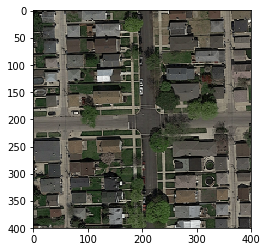

In [9]:
plt.imshow(scaled_imgs[0])

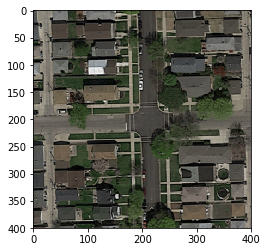

In [10]:
plt.imshow(scaled_imgs[1])

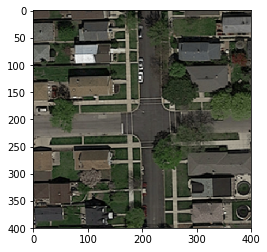

In [11]:
plt.imshow(scaled_imgs[2])

## Image Rotation

In [12]:
def rotate_images(X_imgs):
    X_rotate = []
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, shape = (IMAGE_SIZE, IMAGE_SIZE, 3))
    k = tf.placeholder(tf.int32)
    tf_img = tf.image.rot90(X, k = k)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for img in X_imgs:
            for i in range(3):  # Rotation at 90, 180 and 270 degrees
                rotated_img = sess.run(tf_img, feed_dict = {X: img, k: i + 1})
                X_rotate.append(rotated_img)
        
    X_rotate = np.array(X_rotate, dtype = np.float32)
    return X_rotate

rotated_imgs = rotate_images(imgs)

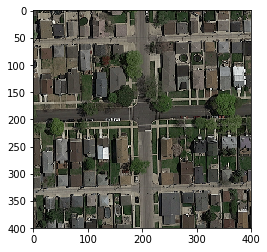

In [13]:
plt.imshow(rotated_imgs[0])

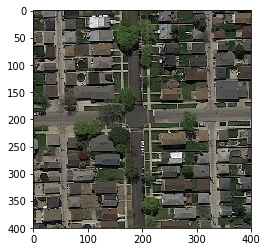

In [14]:
plt.imshow(rotated_imgs[1])

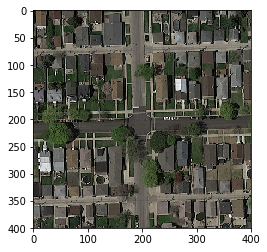

In [15]:
plt.imshow(rotated_imgs[2])

## Image Flipping

In [16]:
def flip_images(X_imgs):
    X_flip = []
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, shape = (IMAGE_SIZE, IMAGE_SIZE, 3))
    tf_img1 = tf.image.flip_left_right(X)
    tf_img2 = tf.image.flip_up_down(X)
    tf_img3 = tf.image.transpose_image(X)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for img in X_imgs:
            flipped_imgs = sess.run([tf_img1, tf_img2, tf_img3], feed_dict = {X: img})
            X_flip.extend(flipped_imgs)
    X_flip = np.array(X_flip, dtype = np.float32)
    return X_flip

flipped_images = flip_images(imgs)

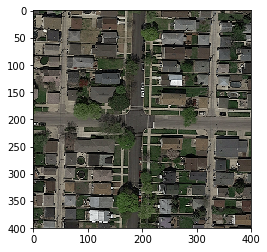

In [17]:
plt.imshow(flipped_images[0])

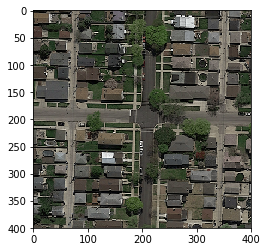

In [18]:
plt.imshow(flipped_images[1])

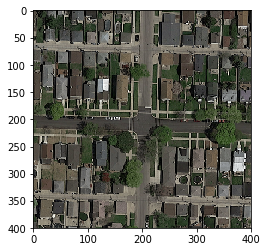

In [19]:
plt.imshow(flipped_images[2])

## Adding Salt and Pepper Noise

In [39]:
def add_salt_pepper_noise(X_imgs):
    # Need to produce a copy as to not modify the original image
    X_imgs_copy = X_imgs.copy()
    row, col, _ = X_imgs_copy[0].shape
    salt_vs_pepper = 0.2
    amount = 0.004
    num_salt = np.ceil(amount * X_imgs_copy[0].size * salt_vs_pepper)
    num_pepper = np.ceil(amount * X_imgs_copy[0].size * (1.0 - salt_vs_pepper))
    
    for X_img in X_imgs_copy:
        # Add Salt noise
        coords = [np.random.randint(0, i - 1, int(num_salt)) for i in X_img.shape]
        X_img[coords[0], coords[1], :] = 1

        # Add Pepper noise
        coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in X_img.shape]
        X_img[coords[0], coords[1], :] = 0
    return X_imgs_copy
  
salt_pepper_noise_imgs = add_salt_pepper_noise(imgs)

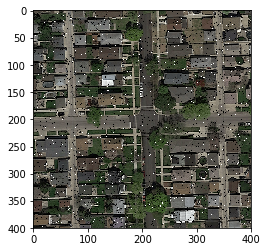

In [40]:
plt.imshow(salt_pepper_noise_imgs[0])

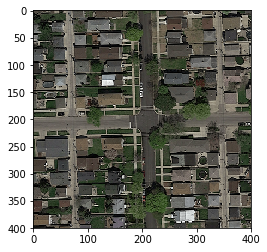

In [20]:
plt.imshow(imgs[0])

## Lighting Condition

In [21]:
import cv2

def add_gaussian_noise(X_imgs):
    gaussian_noise_imgs = []
    row, col, _ = X_imgs[0].shape
    # Gaussian distribution parameters
    mean = 0
    var = 0.1
    sigma = var ** 0.5
    
    for X_img in X_imgs:
        gaussian = np.random.random((row, col, 1)).astype(np.float32)
        gaussian = np.concatenate((gaussian, gaussian, gaussian), axis = 2)
        gaussian_img = cv2.addWeighted(X_img, 0.75, 0.25 * gaussian, 0.25, 0)
        gaussian_noise_imgs.append(gaussian_img)
    gaussian_noise_imgs = np.array(gaussian_noise_imgs, dtype = np.float32)
    return gaussian_noise_imgs
  
gaussian_noise_imgs = add_gaussian_noise(imgs)

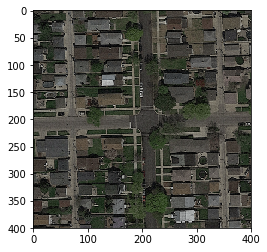

In [22]:
plt.imshow(gaussian_noise_imgs[0])

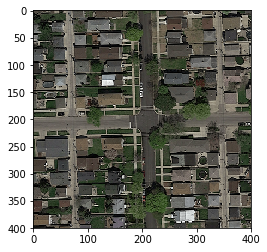

In [23]:
plt.imshow(imgs[0])

# Basic Model

In [9]:
images = extract_data(image_dir, 20)

Loading training/images/satImage_001.png
Loading training/images/satImage_002.png
Loading training/images/satImage_003.png
Loading training/images/satImage_004.png
Loading training/images/satImage_005.png
Loading training/images/satImage_006.png
Loading training/images/satImage_007.png
Loading training/images/satImage_008.png
Loading training/images/satImage_009.png
Loading training/images/satImage_010.png
Loading training/images/satImage_011.png
Loading training/images/satImage_012.png
Loading training/images/satImage_013.png
Loading training/images/satImage_014.png
Loading training/images/satImage_015.png
Loading training/images/satImage_016.png
Loading training/images/satImage_017.png
Loading training/images/satImage_018.png
Loading training/images/satImage_019.png
Loading training/images/satImage_020.png


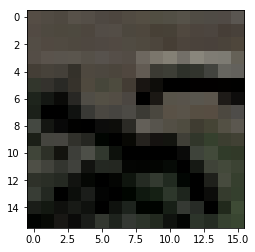

In [11]:
plt.imshow(images[0])

In [13]:
ground_truths = extract_labels(gt_dir, 20)

Loading training/groundtruth/satImage_001.png
Loading training/groundtruth/satImage_002.png
Loading training/groundtruth/satImage_003.png
Loading training/groundtruth/satImage_004.png
Loading training/groundtruth/satImage_005.png
Loading training/groundtruth/satImage_006.png
Loading training/groundtruth/satImage_007.png
Loading training/groundtruth/satImage_008.png
Loading training/groundtruth/satImage_009.png
Loading training/groundtruth/satImage_010.png
Loading training/groundtruth/satImage_011.png
Loading training/groundtruth/satImage_012.png
Loading training/groundtruth/satImage_013.png
Loading training/groundtruth/satImage_014.png
Loading training/groundtruth/satImage_015.png
Loading training/groundtruth/satImage_016.png
Loading training/groundtruth/satImage_017.png
Loading training/groundtruth/satImage_018.png
Loading training/groundtruth/satImage_019.png
Loading training/groundtruth/satImage_020.png


In [16]:
plt.imshow()

TypeError: imshow() missing 1 required positional argument: 'X'

In [19]:
ground_truths.shape

(12500, 2)

In [21]:
print('Image shape: ', images.shape)
print('Ground truth shape:', ground_truths.shape)                      

Image shape:  (12500, 16, 16, 3)
Ground truth shape: (12500, 2)


In [362]:
TRAIN_TEST_SPLIT = 0.8

# Split into test and training sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, ground_truths, train_size = TRAIN_TEST_SPLIT, random_state = 0)

print('Shape of X_train:', X_train.shape)
print('Shape of X_test:', X_test.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train: (10000, 16, 16, 3)
Shape of X_test: (2500, 16, 16, 3)
Shape of y_train: (10000, 2)
Shape of y_test: (2500, 2)


In [370]:
def cnn(image_size, n_layers):
    """
    INPUTS:
     - image_size (size of the input images)
     - n_layers (number of layers)
    OUTPUT:
     - model (compiled CNN)
     """

    # Define hyperparamters
    MIN_NEURONS = 20
    MAX_NEURONS = 120
    KERNEL = (3, 3)

    # Determine the # of neurons in each convolutional layer
    steps = np.floor(MAX_NEURONS / (n_layers + 1))
    nuerons = np.arange(MIN_NEURONS, MAX_NEURONS, steps)
    nuerons = nuerons.astype(np.int32)
    
    ordering = 'channels_last'
    
    # Define a model
    model = Sequential()

    # Add convolutional layers
    for i in range(0, n_layers):
        if i == 0:
            shape = (image_size[0], image_size[1], image_size[2])
            print(shape)
            model.add(Conv2D(nuerons[i], KERNEL, input_shape=shape))
        else:
            model.add(Conv2D(nuerons[i], KERNEL))

        model.add(Activation('relu'))

    # Add max pooling layer
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(MAX_NEURONS))
    model.add(Activation('relu'))

    # Add output layer
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    # Print a summary of the model
    model.summary()

    return model

In [377]:
# Instantiate the model
model = cnn(image_size=image_size, n_layers=N_LAYERS)

(16, 16, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_107 (Conv2D)          (None, 14, 14, 20)        560       
_________________________________________________________________
activation_133 (Activation)  (None, 14, 14, 20)        0         
_________________________________________________________________
conv2d_108 (Conv2D)          (None, 12, 12, 44)        7964      
_________________________________________________________________
activation_134 (Activation)  (None, 12, 12, 44)        0         
_________________________________________________________________
conv2d_109 (Conv2D)          (None, 10, 10, 68)        26996     
_________________________________________________________________
activation_135 (Activation)  (None, 10, 10, 68)        0         
_________________________________________________________________
conv2d_110 (Conv2D)          (None, 8, 8, 92)          56396    

In [365]:
# Training hyperparameters
EPOCHS = 150
BATCH_SIZE = 200

In [366]:
# Early stopping callback
PATIENCE = 10
early_stopping = EarlyStopping(monitor='loss', min_delta=0, patience=PATIENCE, verbose=0, mode='auto')

In [367]:
# TensorBoard callback
LOG_DIRECTORY_ROOT = ''
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
log_dir = "{}/run-{}/".format(LOG_DIRECTORY_ROOT, now)
tensorboard = TensorBoard(log_dir=log_dir, write_graph=True, write_images=True)

In [368]:
# Place the callbacks in a list
callbacks = [early_stopping, tensorboard]

In [369]:
# Train the model  epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks, verbose=0
model.fit(X_train, y_train)

ValueError: Error when checking target: expected activation_132 to have shape (1,) but got array with shape (2,)